Step 1: Imports and Setup

In [2]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jekyt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Step 2: Data Loading and Combination

In [3]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

In [4]:
# Files are stored in the 'content' folder.
fake_path = os.path.join("content", "Fake.csv")
true_path = os.path.join("content", "True.csv")

In [5]:
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add a label column: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

In [6]:
# Concatenate the DataFrames
df = pd.concat([fake_df, true_df], ignore_index=True)

# Keep only the necessary columns: title, text, and label.
df = df[['title', 'text', 'label']]

Step 3: Data Cleaning and Preprocessing

In [8]:
# Check and drop missing values
print("Missing values before:", df.isnull().sum())
df.dropna(inplace=True)
print("Missing values after:", df.isnull().sum())

Missing values before: title    0
text     0
label    0
dtype: int64
Missing values after: title    0
text     0
label    0
dtype: int64


In [9]:
# Create a new column 'combined_text' that concatenates the title and text.
df['combined_text'] = df['title'] + ' ' + df['text']

In [10]:
# --- Text Cleaning Function ---
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['combined_text'] = df['combined_text'].apply(clean_text)

Step 4: Tokenization

In [11]:
# We use a simple whitespace split. (Alternatively, nltk.word_tokenize can be used)
def tokenize(text):
    return text.split()

df['tokens'] = df['combined_text'].apply(tokenize)

Step 5: Build Vocabulary and Word-to-Index Mapping

In [12]:
MAX_VOCAB_SIZE = 20000  # Limit vocabulary size
counter = Counter([word for tokens in df['tokens'] for word in tokens])
most_common = counter.most_common(MAX_VOCAB_SIZE - 2)  # Reserve indices for <PAD> and <UNK>

Step 6: Convert Tokens to Sequences and Padding

In [13]:
word2idx = {"<PAD>": 0, "<UNK>": 1}
for idx, (word, _) in enumerate(most_common, start=2):
    word2idx[word] = idx

# Compute vocabulary size from the word-to-index mapping
vocab_size = len(word2idx)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 20000


Convert Tokens to Sequences

In [14]:
def tokens_to_sequence(tokens, word2idx):
    return [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]

df['sequence'] = df['tokens'].apply(lambda x: tokens_to_sequence(x, word2idx))


Padding Sequences

In [15]:
MAX_SEQUENCE_LENGTH = 200  # Adjust this value based on distribution or experimentation

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

df['padded_seq'] = df['sequence'].apply(lambda x: pad_sequence(x, MAX_SEQUENCE_LENGTH))

In [16]:
# Prepare features and labels
X = np.array(df['padded_seq'].tolist())
y = df['label'].values

print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

Feature shape: (44898, 200)
Labels shape: (44898,)


Step 7: Pre-trained Embeddings (GloVe)

In [17]:
import os
import re
import numpy as np

EMBEDDING_DIM = 100  # Dimensionality of the GloVe embeddings
GLOVE_DIR = 'glove.6B' #  Create a folder named 'glove.6B' in the 'content' directory. Place glove.6B.100d.txt inside it.
embeddings_index = {}

try:
    with open(os.path.join('content', GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("GloVe file not found. Please download 'glove.6B.zip' from https://nlp.stanford.edu/projects/glove/,")
    print("extract it, and place 'glove.6B.100d.txt' in a folder named 'glove.6B' inside the 'content' directory.")
    exit() # Stop execution if the file is not found.

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
# Prepare the embedding matrix
vocab_size = len(word2idx)  # Ensure vocab_size is defined
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    # If word is not in GloVe, the row remains zeros
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (20000, 100)


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

Step 8: Create Dataset and DataLoaders

In [20]:
class FakeNewsClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout_prob, embedding_matrix, trainable_embedding=False):
        """
        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the LSTM hidden state.
            output_dim (int): Dimension of the output (1 for binary classification).
            n_layers (int): Number of LSTM layers.
            dropout_prob (float): Dropout probability.
            embedding_matrix (np.array): Pre-trained embedding weights.
            trainable_embedding (bool): Whether the embedding layer weights should be trained.
        """
        super(FakeNewsClassifierLSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Load pre-trained embeddings
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = trainable_embedding

        # 2. LSTM Layer(s)
        # Only apply internal dropout if n_layers > 1
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            dropout=dropout_prob if n_layers > 1 else 0,
                            batch_first=True,
                            bidirectional=False)

        # 3. Dropout Layer (applied after LSTM)
        self.dropout = nn.Dropout(dropout_prob)

        # 4. Dense Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 5. Output Layer Activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Get last hidden state from the last LSTM layer
        last_hidden_state = hidden[-1]  # (batch_size, hidden_dim)
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return self.sigmoid(out).squeeze()  # Squeeze to match shape for loss

Step 9: Model Definition

In [21]:
# Create a custom Dataset and DataLoaders for training and testing
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

# Create DataLoaders
BATCH_SIZE = 128  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Step 10: Training and Evaluation Loop

In [22]:
# Module 2: Training and Evaluation Loop with Metrics
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Hyperparameters (adjust as needed)
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT_PROB = 0.3
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
TRAINABLE_EMBEDDING = False

# Instantiate the model using the enhanced definition from Module 1
model = FakeNewsClassifierLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout_prob=DROPOUT_PROB,
    embedding_matrix=embedding_matrix,
    trainable_embedding=TRAINABLE_EMBEDDING
)
print(model)

# Count parameters (optional)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion.to(device)

# Training loop with metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    model.train()
    running_train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X)
            loss = criterion(preds, batch_y)
            running_val_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = running_val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)
    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

    val_accuracy = accuracy_score(all_labels, binary_preds)
    val_precision = precision_score(all_labels, binary_preds, zero_division=0)
    val_recall = recall_score(all_labels, binary_preds, zero_division=0)
    val_f1 = f1_score(all_labels, binary_preds, zero_division=0)

    history['val_accuracy'].append(val_accuracy)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - {epoch_time:.2f}s - Train Loss: {avg_train_loss:.4f} - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f} - "
          f"Val Prec: {val_precision:.4f} - Val Rec: {val_recall:.4f} - Val F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_lstm_model.pth')

training_time = time.time() - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


FakeNewsClassifierLSTM(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Total Parameters: 2,117,889
Trainable Parameters: 117,889
Using device: cpu
Epoch 1/5 - 29.72s - Train Loss: 0.4491 - Val Loss: 0.4009 - Val Acc: 0.8523 - Val Prec: 0.8992 - Val Rec: 0.7747 - Val F1: 0.8323
Epoch 2/5 - 24.75s - Train Loss: 0.5474 - Val Loss: 0.6876 - Val Acc: 0.5305 - Val Prec: 0.9697 - Val Rec: 0.0075 - Val F1: 0.0150
Epoch 3/5 - 25.21s - Train Loss: 0.6538 - Val Loss: 0.3983 - Val Acc: 0.9020 - Val Prec: 0.8891 - Val Rec: 0.9058 - Val F1: 0.8974
Epoch 4/5 - 26.19s - Train Loss: 0.5108 - Val Loss: 0.2783 - Val Acc: 0.9241 - Val Prec: 0.8898 - Val Rec: 0.9581 - Val F1: 0.9227
Epoch 5/5 - 25.06s - Train Loss: 0.2197 - Val Loss: 0.1060 - Val Acc: 0.9737 - Val Prec: 0.9534 - Val Rec: 0.9929 - Val F1: 0.9728
Total Training Time: 13

Step 11: Plotting and Insights

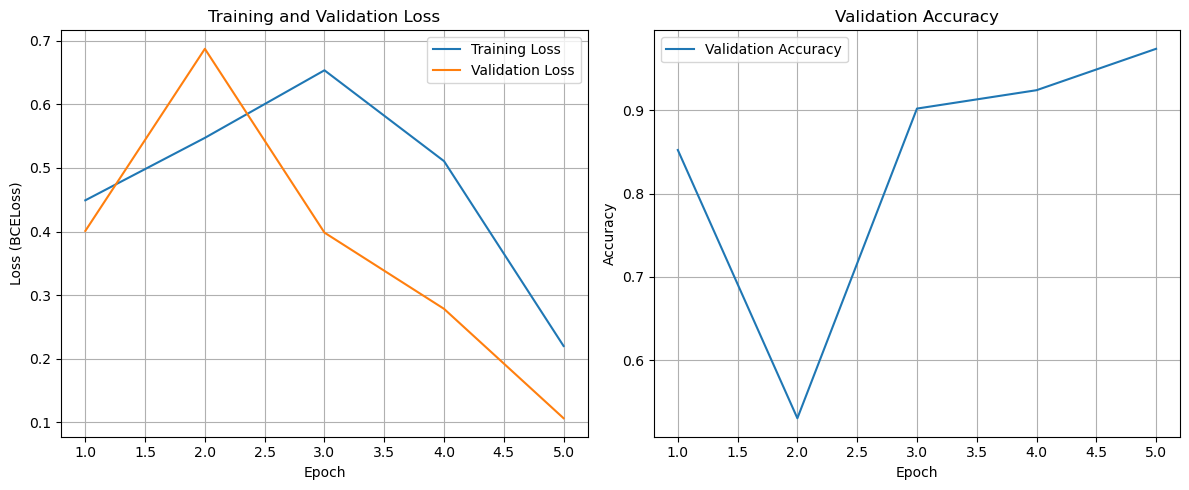

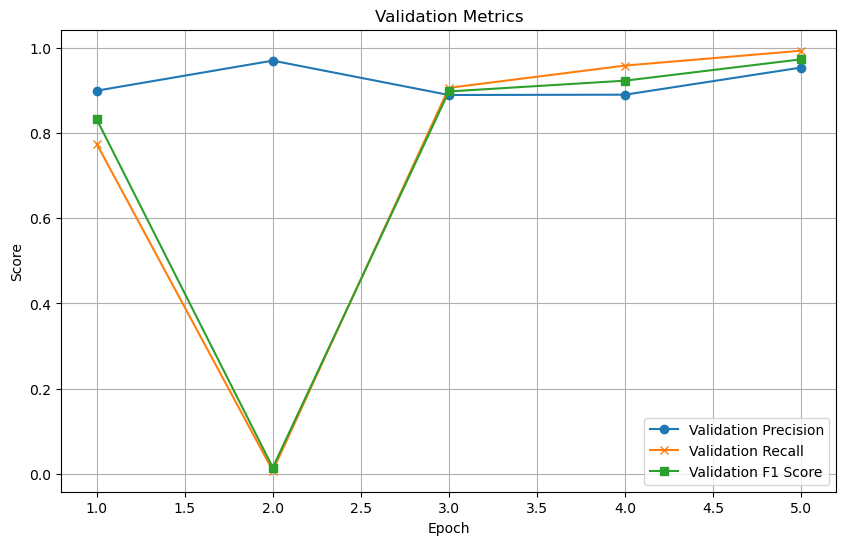

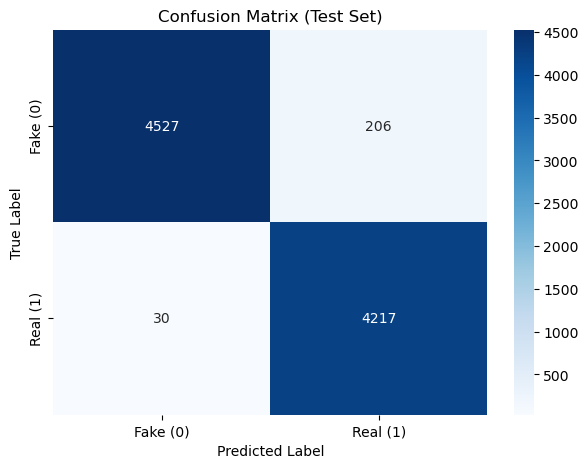

In [23]:
# Module 3: Plotting and Insights
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCELoss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Precision, Recall, F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['val_precision'], label='Validation Precision', marker='o')
plt.plot(epochs_range, history['val_recall'], label='Validation Recall', marker='x')
plt.plot(epochs_range, history['val_f1'], label='Validation F1 Score', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix using predictions from the last validation epoch
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
